# Studying RNNs with an artificial dataset

Idea: RNNs, iike RNNs, are "pattern detectors".

RNNs detect patterns by remembering what has been seen before.  They maintain state that partially records all previous inputs.

to do:
- write numpy code to replicate predictions from stacked and backward models
- try an artificial data set in which there are two classes: one with a single random 'blip', and another with two random blips.

In [16]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras import backend as K

In [17]:
# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 600)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.figsize'] = 4,3

This custom callback allows for training to stop when a high accuracy is achieved.

Source: https://stackoverflow.com/questions/53500047/stop-training-in-keras-when-accuracy-is-already-1-0

In [19]:
class TerminateOnBaseline(Callback):
    """Callback that terminates training when either acc or val_acc reaches a specified baseline
    """
    def __init__(self, monitor='accuracy', baseline=0.9):
        super(TerminateOnBaseline, self).__init__()
        self.monitor = monitor
        self.baseline = baseline

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get(self.monitor)
        if acc is not None:
            if acc >= self.baseline:
                print('Epoch %d: Reached baseline, terminating training' % (epoch))
                self.model.stop_training = True

In [20]:
# Code based on a ChatGPT answer

def dataframe_to_series(df):
    """ Convert a specially-formatted dataframe to a rank-3 NumPy array
    of shape (num_series, num_steps, num_channels).
    """

    df_sorted = df.sort_values(by=['Time_Series_ID', 'Time_Step'])

    # Extract the number of time series and number of time steps
    num_series = df['Time_Series_ID'].nunique()
    num_steps  = df['Time_Step'].nunique()

    # Extract the values corresponding to the channels
    # Assuming the channel columns are named as 'Channel_0', 'Channel_1', etc.
    channel_columns = [col for col in df if col.startswith('Channel_')]
    channel_values = df_sorted[channel_columns].values

    # Reshape back to 3D array
    num_channels = len(channel_columns)

    original_shape = (num_series, num_steps, num_channels)
    X = channel_values.reshape(original_shape)

    return X

### Fake EEG data set

In [22]:
def make_eeg_data():
    data_dir = "../../datasets/fake_brain_data/"
    df0 = pd.read_csv(data_dir+'eeg_class0.csv')
    df1 = pd.read_csv(data_dir+'eeg_class1.csv')
    
    X0 = dataframe_to_series(df0)[:500]
    X1 = dataframe_to_series(df1)[:500]
    y0 = np.zeros(X0.shape[0])
    y1 = np.ones(X1.shape[0])
    
    X = np.concatenate([X0, X1])
    y = np.concatenate([y0, y1])    
    
    return X,y

### Create artificial data set

Three classes: sawtooth, sine wave, and impulse.

In [23]:
def create_sawtooth(num_time_steps=10):
    
    xs = []
    x = 0.0
    for i in range(num_time_steps):
        xs.append(x)
        if i < num_time_steps/2:
            x += 0.2
        else:
            x -= 0.2 
            
    return np.array(xs)

def create_sine(num_time_steps=10):
    
    return np.sin(np.linspace(0, np.pi*2, num_time_steps))*0.5 + 0.5    

def create_impulse(num_time_steps=10):

    xs = np.zeros(num_time_steps)
    loc = num_time_steps // 2
    xs[loc-1] = 0.8
    xs[loc]   = 0.8
    return xs

def make_ts_data(patterns, num_time_steps=10, instances_per_class=150, noise_scale=0.05):
    """ Generate univariate time-series data.
    
    Arguments:
    - patterns: list containing at least two of 'sawtooth', 'sine', and 'impulse'
    - num_time_steps: length of the generated times series
    - instances_per_class: number of series generated per class
    Returns:
    - X: a NumPy array of shape (instances_per_class * len(patterns), num_time_steps)
    - y: a NumPy array of shape (instance_per_class * len(patterns),) containing the class labels 0, 1, ...
    """
    
    num_classes = len(patterns)
    
    # create pattern data
    pattern = np.zeros((num_classes, num_time_steps))
    for i, p in enumerate(patterns):
        if p == 'sawtooth':
            pattern[i] = create_sawtooth(num_time_steps)            
        elif p == 'sine':
            pattern[i] = create_sine(num_time_steps)
        elif p == 'impulse':
            pattern[i] = create_impulse(num_time_steps)
        else:
            sys.exit(f"pattern {p} is unsupported")
            
    # create data by adding noise to patterns
    m = num_classes * instances_per_class
    X = np.zeros((m, num_time_steps))
    y = np.zeros(m)
    for i in range(num_classes):
        for j in range(instances_per_class):
            X[i*instances_per_class+j] = pattern[i] + np.random.normal(scale=noise_scale, size=num_time_steps)
            y[i*instances_per_class+j] = i
            
    return np.expand_dims(X, axis=2), y

In [24]:
X, y = make_ts_data(['sawtooth', 'sine', 'impulse'])
print(X.shape)
print(y.shape)

(450, 10, 1)
(450,)


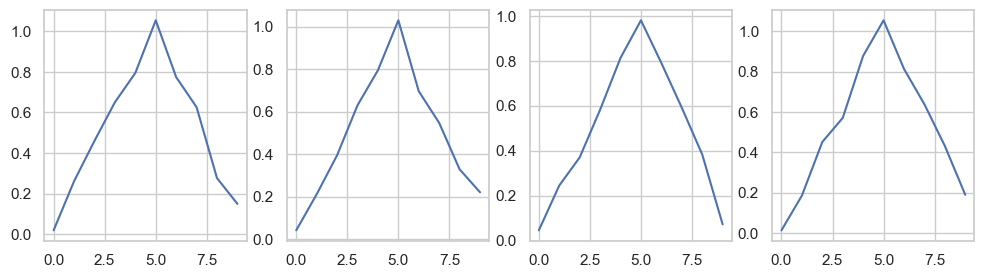

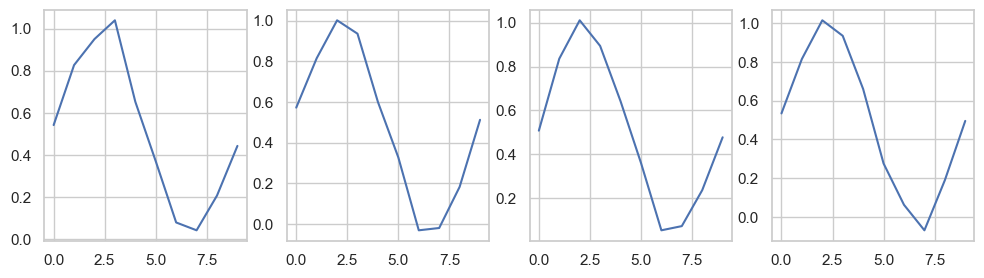

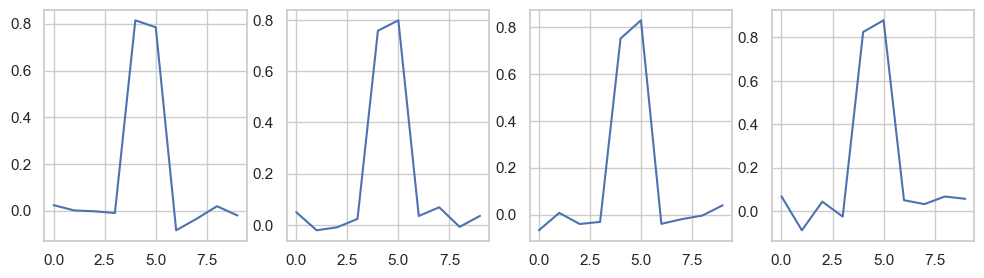

In [25]:
# test make_ts_data()

X, y = make_ts_data(['sawtooth', 'sine', 'impulse'])

num_classes = np.unique(y).size
num_examples = 4
for j in range(num_classes):
    fig,axs = plt.subplots(1, num_examples, figsize=(num_examples*3,3))
    Xj = X[y == j]
    idx = np.random.choice(Xj.shape[0], num_examples)
    for ax, i in zip(axs, idx):
        ax.plot(Xj[i])
    plt.show()

### A binary classifier with one neuron

A single input at each step and a single output.

In [26]:
X, y = make_ts_data(['sawtooth', 'sine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [27]:
K.clear_session()

inputs = Input(shape=(X_train.shape[1:]))
x = layers.SimpleRNN(1)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [260]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [261]:
early_stopping = TerminateOnBaseline(monitor='val_accuracy', baseline=0.999)
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/500
10/10 [==============================] - 1s 18ms/step - loss: 0.6931 - accuracy: 0.4898 - val_loss: 0.6927 - val_accuracy: 0.5397
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6926 - accuracy: 0.5442 - val_loss: 0.6924 - val_accuracy: 0.5397
Epoch 3/500
10/10 [==============================] - 0s 10ms/step - loss: 0.6924 - accuracy: 0.5850 - val_loss: 0.6921 - val_accuracy: 0.5714
Epoch 4/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6921 - accuracy: 0.6054 - val_loss: 0.6918 - val_accuracy: 0.5079
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6917 - accuracy: 0.6327 - val_loss: 0.6915 - val_accuracy: 0.6032
Epoch 6/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6912 - accuracy: 0.6327 - val_loss: 0.6910 - val_accuracy: 0.6508
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.6871 - val_loss: 0.6905 - val_accuracy: 0.7143
Epoch 8/500

In [262]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.6627 - accuracy: 0.9889


[0.6627432107925415, 0.9888888597488403]

In [263]:
X_train[0].shape

(10, 1)

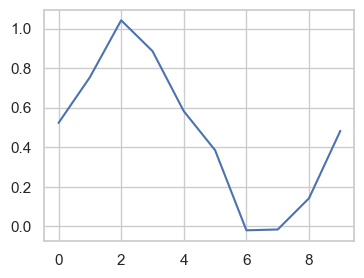

In [264]:
plt.plot(X_train[0]);

In [265]:
model.predict(X_train[[0]]).round(5)

array([[0.52098]], dtype=float32)

In [266]:
np.argmax(model.predict(X_train[:1]))

0

#### Get the model weights

In [89]:
model.layers

In [90]:
rnn_weights   = model.get_layer('simple_rnn').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [91]:
print(rnn_weights)
print(dense_weights)

[array([[0.78508353]], dtype=float32), array([[0.85662705]], dtype=float32), array([-0.2725596], dtype=float32)]
[array([[-1.6259283]], dtype=float32), array([0.17650339], dtype=float32)]


In [92]:
rnn_weights[0].shape

(1, 1)

In [93]:
dense_weights[0].shape

(1, 1)

In [94]:
model.get_layer('simple_rnn').get_weights()

[array([[0.78508353]], dtype=float32),
 array([[0.85662705]], dtype=float32),
 array([-0.2725596], dtype=float32)]

In [95]:
w = rnn_weights[0][0,0]
u = rnn_weights[1][0,0]
rnn_bias = rnn_weights[2][0]
v = dense_weights[0][0,0]
dense_bias = dense_weights[1][0]

In [96]:
print(f'h[t+1] = tanh({w:.3g}*x[t] + {u:.3g}*h[t] + {rnn_bias:.3g})')

h[t+1] = tanh(0.785*x[t] + 0.857*h[t] + -0.273)


### Implement the forward pass by hand and see if getting the same predictions

My original version, no dot product.

In [160]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [98]:
def binary_rnn_predict(rnn_weights, dense_weights, x):
    
    w = rnn_weights[0][0,0]
    u = rnn_weights[1][0,0]
    rnn_bias = rnn_weights[2][0]
    v = dense_weights[0][0,0]
    dense_bias = dense_weights[1][0]
    
    # rnn 
    hidden_state = 0.0
    for t in range(x.shape[0]):
        hidden_state = np.tanh(w * x[t] + u * hidden_state + rnn_bias)
       
    # output layer
    return sigmoid(v * hidden_state + dense_bias)

In [99]:
# first training example
binary_rnn_predict(rnn_weights, dense_weights, X_train[0]).round(4)

array([0.6158])

In [100]:
# first training example
model.predict(X_train[[0]]).round(4)

array([[0.6158]], dtype=float32)

In [101]:
# an alternative version in which hidden states are recorded
def binary_rnn_predict(rnn_weights, dense_weights, x):
    
    w = rnn_weights[0][0,0]
    u = rnn_weights[1][0,0]
    rnn_bias = rnn_weights[2][0]
    v = dense_weights[0][0,0]
    dense_bias = dense_weights[1][0]
    
    # rnn 
    hidden_states = np.zeros(x.shape[0] + 1)
    for t in range(x.shape[0]):
        hidden_states[t+1] = np.tanh(w * x[t] + u * hidden_states[t] + rnn_bias)
       
    # output layer
    return sigmoid(v * hidden_states[t+1] + dense_bias), hidden_states

In [102]:
binary_rnn_predict(rnn_weights, dense_weights, X_train[0])[0].round(4)

0.6158

In [103]:
y, hidden_states = binary_rnn_predict(rnn_weights, dense_weights, X_train[0])

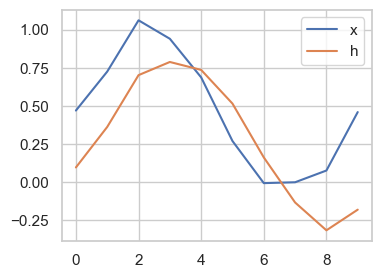

In [104]:
plt.plot(X_train[0], label='x')
plt.plot(hidden_states[1:], label='h')
plt.legend()
plt.show()

In [105]:
# second training example
binary_rnn_predict(rnn_weights, dense_weights, X_train[1])[0].round(4)

0.412

In [106]:
# second training example
model.predict(X_train[[1]]).round(5).round(4)

array([[0.412]], dtype=float32)

In [107]:
y, hidden_states = binary_rnn_predict(rnn_weights, dense_weights, X_train[1])

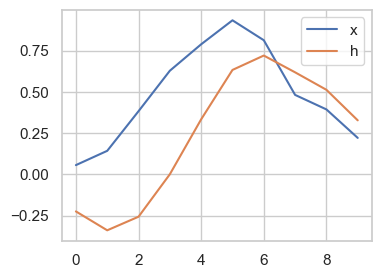

In [108]:
plt.plot(X_train[1], label='x')
plt.plot(hidden_states[1:], label='h')
plt.legend()
plt.show()

### A multi-class classifier with one recurrent neuron

Again, a single input and a single output.

In [111]:
X, y = make_ts_data(['sawtooth', 'sine', 'impulse'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
num_classes = 3

In [113]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.SimpleRNN(1)(inputs)
x = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, x)

In [114]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 3)                 6         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
early_stopping = TerminateOnBaseline(monitor='val_accuracy', baseline=0.99)
model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/1000
7/7 [==============================] - 1s 24ms/step - loss: 1.0787 - accuracy: 0.3909 - val_loss: 1.0706 - val_accuracy: 0.4000
Epoch 2/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.0766 - accuracy: 0.3864 - val_loss: 1.0689 - val_accuracy: 0.4000
Epoch 3/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0752 - accuracy: 0.3818 - val_loss: 1.0675 - val_accuracy: 0.4000
Epoch 4/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0738 - accuracy: 0.3909 - val_loss: 1.0659 - val_accuracy: 0.4000
Epoch 5/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0724 - accuracy: 0.3818 - val_loss: 1.0645 - val_accuracy: 0.4000
Epoch 6/1000
7/7 [==============================] - 0s 6ms/step - loss: 1.0710 - accuracy: 0.3909 - val_loss: 1.0631 - val_accuracy: 0.4000
Epoch 7/1000
7/7 [==============================] - 0s 7ms/step - loss: 1.0696 - accuracy: 0.3955 - val_loss: 1.0616 - val_accuracy: 0.4000
Epoch 8/1000
7/7 [=

7/7 [==============================] - 0s 13ms/step - loss: 0.8299 - accuracy: 0.7182 - val_loss: 0.8180 - val_accuracy: 0.7368
Epoch 118/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.8276 - accuracy: 0.7000 - val_loss: 0.8157 - val_accuracy: 0.7474
Epoch 119/1000
7/7 [==============================] - 0s 12ms/step - loss: 0.8255 - accuracy: 0.7045 - val_loss: 0.8135 - val_accuracy: 0.7474
Epoch 120/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.8232 - accuracy: 0.7045 - val_loss: 0.8113 - val_accuracy: 0.7579
Epoch 121/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.8210 - accuracy: 0.7045 - val_loss: 0.8090 - val_accuracy: 0.7579
Epoch 122/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.8188 - accuracy: 0.7091 - val_loss: 0.8068 - val_accuracy: 0.7579
Epoch 123/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.8166 - accuracy: 0.7045 - val_loss: 0.8046 - val_accuracy: 0.7579
Epoch 124/1000
7

Epoch 175/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7147 - accuracy: 0.7818 - val_loss: 0.7022 - val_accuracy: 0.7684
Epoch 176/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7128 - accuracy: 0.7818 - val_loss: 0.7002 - val_accuracy: 0.7684
Epoch 177/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7109 - accuracy: 0.7955 - val_loss: 0.6983 - val_accuracy: 0.7684
Epoch 178/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7090 - accuracy: 0.7909 - val_loss: 0.6965 - val_accuracy: 0.7684
Epoch 179/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7071 - accuracy: 0.7955 - val_loss: 0.6945 - val_accuracy: 0.7684
Epoch 180/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7053 - accuracy: 0.8000 - val_loss: 0.6927 - val_accuracy: 0.7684
Epoch 181/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.7034 - accuracy: 0.8000 - val_loss: 0.6908 - val_accuracy: 0.7684
Epoch 

Epoch 290/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5228 - accuracy: 0.9545 - val_loss: 0.5150 - val_accuracy: 0.9263
Epoch 291/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5214 - accuracy: 0.9545 - val_loss: 0.5135 - val_accuracy: 0.9263
Epoch 292/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5200 - accuracy: 0.9545 - val_loss: 0.5122 - val_accuracy: 0.9263
Epoch 293/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5185 - accuracy: 0.9591 - val_loss: 0.5108 - val_accuracy: 0.9263
Epoch 294/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5170 - accuracy: 0.9591 - val_loss: 0.5093 - val_accuracy: 0.9263
Epoch 295/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5156 - accuracy: 0.9591 - val_loss: 0.5079 - val_accuracy: 0.9263
Epoch 296/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.5141 - accuracy: 0.9591 - val_loss: 0.5066 - val_accuracy: 0.9263
Epoch 

Epoch 348/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.4436 - accuracy: 0.9727 - val_loss: 0.4403 - val_accuracy: 0.9368
Epoch 349/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4424 - accuracy: 0.9727 - val_loss: 0.4392 - val_accuracy: 0.9368
Epoch 350/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4411 - accuracy: 0.9727 - val_loss: 0.4379 - val_accuracy: 0.9368
Epoch 351/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4398 - accuracy: 0.9727 - val_loss: 0.4368 - val_accuracy: 0.9368
Epoch 352/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4387 - accuracy: 0.9727 - val_loss: 0.4357 - val_accuracy: 0.9368
Epoch 353/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4373 - accuracy: 0.9727 - val_loss: 0.4345 - val_accuracy: 0.9368
Epoch 354/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.4361 - accuracy: 0.9727 - val_loss: 0.4333 - val_accuracy: 0.9368
Epoch 

Epoch 406/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3777 - accuracy: 0.9727 - val_loss: 0.3789 - val_accuracy: 0.9684
Epoch 407/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3767 - accuracy: 0.9727 - val_loss: 0.3780 - val_accuracy: 0.9684
Epoch 408/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3758 - accuracy: 0.9727 - val_loss: 0.3771 - val_accuracy: 0.9684
Epoch 409/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3747 - accuracy: 0.9727 - val_loss: 0.3762 - val_accuracy: 0.9789
Epoch 410/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3738 - accuracy: 0.9727 - val_loss: 0.3753 - val_accuracy: 0.9789
Epoch 411/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.3728 - accuracy: 0.9727 - val_loss: 0.3744 - val_accuracy: 0.9789
Epoch 412/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.3719 - accuracy: 0.9727 - val_loss: 0.3736 - val_accuracy: 0.9789
Epoch 

Epoch 521/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2812 - accuracy: 0.9864 - val_loss: 0.2908 - val_accuracy: 0.9789
Epoch 522/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2804 - accuracy: 0.9864 - val_loss: 0.2901 - val_accuracy: 0.9789
Epoch 523/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2797 - accuracy: 0.9864 - val_loss: 0.2894 - val_accuracy: 0.9789
Epoch 524/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2790 - accuracy: 0.9864 - val_loss: 0.2888 - val_accuracy: 0.9789
Epoch 525/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2783 - accuracy: 0.9864 - val_loss: 0.2882 - val_accuracy: 0.9789
Epoch 526/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2776 - accuracy: 0.9864 - val_loss: 0.2875 - val_accuracy: 0.9789
Epoch 527/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2771 - accuracy: 0.9864 - val_loss: 0.2869 - val_accuracy: 0.9789
Epoch 

Epoch 579/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2445 - accuracy: 0.9864 - val_loss: 0.2580 - val_accuracy: 0.9789
Epoch 580/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2441 - accuracy: 0.9864 - val_loss: 0.2576 - val_accuracy: 0.9789
Epoch 581/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2436 - accuracy: 0.9864 - val_loss: 0.2570 - val_accuracy: 0.9789
Epoch 582/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2429 - accuracy: 0.9864 - val_loss: 0.2566 - val_accuracy: 0.9789
Epoch 583/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2423 - accuracy: 0.9864 - val_loss: 0.2562 - val_accuracy: 0.9789
Epoch 584/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2419 - accuracy: 0.9864 - val_loss: 0.2556 - val_accuracy: 0.9789
Epoch 585/1000
7/7 [==============================] - 0s 6ms/step - loss: 0.2413 - accuracy: 0.9864 - val_loss: 0.2551 - val_accuracy: 0.9789
Epoch 

Epoch 637/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2145 - accuracy: 0.9864 - val_loss: 0.2316 - val_accuracy: 0.9789
Epoch 638/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2141 - accuracy: 0.9864 - val_loss: 0.2311 - val_accuracy: 0.9789
Epoch 639/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2135 - accuracy: 0.9864 - val_loss: 0.2307 - val_accuracy: 0.9789
Epoch 640/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2133 - accuracy: 0.9864 - val_loss: 0.2303 - val_accuracy: 0.9789
Epoch 641/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2127 - accuracy: 0.9864 - val_loss: 0.2298 - val_accuracy: 0.9789
Epoch 642/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2122 - accuracy: 0.9864 - val_loss: 0.2296 - val_accuracy: 0.9789
Epoch 643/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.2117 - accuracy: 0.9864 - val_loss: 0.2292 - val_accuracy: 0.9789
Epoch 

Epoch 695/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1893 - accuracy: 0.9864 - val_loss: 0.2094 - val_accuracy: 0.9789
Epoch 696/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1888 - accuracy: 0.9864 - val_loss: 0.2091 - val_accuracy: 0.9789
Epoch 697/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1887 - accuracy: 0.9864 - val_loss: 0.2089 - val_accuracy: 0.9789
Epoch 698/1000
7/7 [==============================] - 0s 9ms/step - loss: 0.1881 - accuracy: 0.9864 - val_loss: 0.2085 - val_accuracy: 0.9789
Epoch 699/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1877 - accuracy: 0.9864 - val_loss: 0.2082 - val_accuracy: 0.9789
Epoch 700/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1874 - accuracy: 0.9864 - val_loss: 0.2078 - val_accuracy: 0.9789
Epoch 701/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1871 - accuracy: 0.9864 - val_loss: 0.2075 - val_accuracy: 0.9789
Epoch 

Epoch 753/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1683 - accuracy: 0.9864 - val_loss: 0.1910 - val_accuracy: 0.9789
Epoch 754/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1679 - accuracy: 0.9864 - val_loss: 0.1908 - val_accuracy: 0.9789
Epoch 755/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1675 - accuracy: 0.9864 - val_loss: 0.1904 - val_accuracy: 0.9789
Epoch 756/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1673 - accuracy: 0.9864 - val_loss: 0.1901 - val_accuracy: 0.9789
Epoch 757/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1668 - accuracy: 0.9864 - val_loss: 0.1899 - val_accuracy: 0.9789
Epoch 758/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1665 - accuracy: 0.9864 - val_loss: 0.1895 - val_accuracy: 0.9789
Epoch 759/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1662 - accuracy: 0.9864 - val_loss: 0.1893 - val_accuracy: 0.9789
Epoch 

7/7 [==============================] - 0s 8ms/step - loss: 0.1355 - accuracy: 0.9864 - val_loss: 0.1628 - val_accuracy: 0.9789
Epoch 868/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1353 - accuracy: 0.9864 - val_loss: 0.1626 - val_accuracy: 0.9789
Epoch 869/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1351 - accuracy: 0.9864 - val_loss: 0.1624 - val_accuracy: 0.9789
Epoch 870/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1350 - accuracy: 0.9864 - val_loss: 0.1622 - val_accuracy: 0.9789
Epoch 871/1000
7/7 [==============================] - 0s 10ms/step - loss: 0.1347 - accuracy: 0.9864 - val_loss: 0.1620 - val_accuracy: 0.9789
Epoch 872/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.1344 - accuracy: 0.9864 - val_loss: 0.1619 - val_accuracy: 0.9789
Epoch 873/1000
7/7 [==============================] - 0s 11ms/step - loss: 0.1341 - accuracy: 0.9864 - val_loss: 0.1616 - val_accuracy: 0.9789
Epoch 874/1000
7/7

Epoch 925/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1224 - accuracy: 0.9864 - val_loss: 0.1516 - val_accuracy: 0.9789
Epoch 926/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1224 - accuracy: 0.9864 - val_loss: 0.1514 - val_accuracy: 0.9789
Epoch 927/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1221 - accuracy: 0.9864 - val_loss: 0.1512 - val_accuracy: 0.9789
Epoch 928/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1218 - accuracy: 0.9864 - val_loss: 0.1510 - val_accuracy: 0.9789
Epoch 929/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1216 - accuracy: 0.9864 - val_loss: 0.1508 - val_accuracy: 0.9789
Epoch 930/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1215 - accuracy: 0.9864 - val_loss: 0.1507 - val_accuracy: 0.9789
Epoch 931/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9864 - val_loss: 0.1506 - val_accuracy: 0.9789
Epoch 

Epoch 983/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1113 - accuracy: 0.9864 - val_loss: 0.1422 - val_accuracy: 0.9789
Epoch 984/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1112 - accuracy: 0.9864 - val_loss: 0.1421 - val_accuracy: 0.9789
Epoch 985/1000
7/7 [==============================] - 0s 8ms/step - loss: 0.1110 - accuracy: 0.9864 - val_loss: 0.1419 - val_accuracy: 0.9789
Epoch 986/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1108 - accuracy: 0.9864 - val_loss: 0.1417 - val_accuracy: 0.9789
Epoch 987/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1106 - accuracy: 0.9864 - val_loss: 0.1417 - val_accuracy: 0.9789
Epoch 988/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1105 - accuracy: 0.9864 - val_loss: 0.1414 - val_accuracy: 0.9789
Epoch 989/1000
7/7 [==============================] - 0s 7ms/step - loss: 0.1103 - accuracy: 0.9864 - val_loss: 0.1412 - val_accuracy: 0.9789
Epoch 

In [117]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 0.1100 - accuracy: 0.9926


[0.11004423350095749, 0.9925925731658936]

In [118]:
model.layers

In [119]:
model.get_layer('simple_rnn').get_weights()

[array([[-5.4948773]], dtype=float32),
 array([[0.1829006]], dtype=float32),
 array([1.2683241], dtype=float32)]

In [120]:
model.get_layer('dense').get_weights()

[array([[-0.28374627, -7.3890204 ,  6.427914  ]], dtype=float32),
 array([ 1.855144 , -1.5381631, -1.3002234], dtype=float32)]

In [121]:
print(X_train[0])

[[ 0.50807776]
 [ 0.83874192]
 [ 1.10450745]
 [ 0.99965327]
 [ 0.70257334]
 [ 0.32747508]
 [ 0.1000918 ]
 [-0.02089368]
 [ 0.16909982]
 [ 0.53818444]]


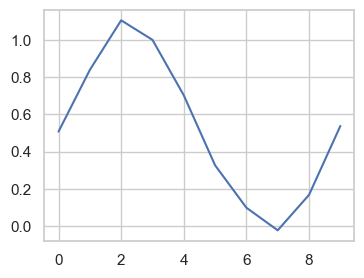

In [122]:
plt.plot(X_train[0]);

In [123]:
model.predict(X_train[:1]).round(2)

array([[0.04, 0.96, 0.  ]], dtype=float32)

In [124]:
np.argmax(model.predict(X_train[:1]))

1

### Binary classification, multiple inputs, single output

In [142]:
X, y = make_eeg_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [143]:
print(X_train.shape)
print(y_train.shape)

(560, 48, 3)
(560,)


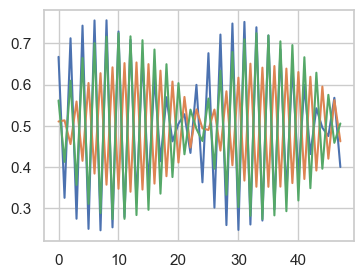

In [121]:
plt.plot(X_train[0]);

In [163]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.SimpleRNN(1)(inputs)   # 1 recurrent neurons
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

In [164]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 3)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 1)                 5         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


In [165]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [166]:
early_stopping = EarlyStopping(patience=8)
history = model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 1s 27ms/step - loss: 0.6989 - accuracy: 0.4872 - val_loss: 0.6896 - val_accuracy: 0.5417
Epoch 2/300
25/25 [==============================] - 0s 19ms/step - loss: 0.6976 - accuracy: 0.4872 - val_loss: 0.6898 - val_accuracy: 0.5417
Epoch 3/300
25/25 [==============================] - 0s 19ms/step - loss: 0.6967 - accuracy: 0.4872 - val_loss: 0.6900 - val_accuracy: 0.5417
Epoch 4/300
25/25 [==============================] - 0s 19ms/step - loss: 0.6960 - accuracy: 0.4872 - val_loss: 0.6904 - val_accuracy: 0.5417
Epoch 5/300
25/25 [==============================] - 1s 22ms/step - loss: 0.6954 - accuracy: 0.4872 - val_loss: 0.6909 - val_accuracy: 0.5417
Epoch 6/300
25/25 [==============================] - 0s 19ms/step - loss: 0.6947 - accuracy: 0.4923 - val_loss: 0.6914 - val_accuracy: 0.5417
Epoch 7/300
25/25 [==============================] - 1s 21ms/step - loss: 0.6944 - accuracy: 0.5077 - val_loss: 0.6918 - val_accuracy: 0.5357
Epoch 

In [90]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5167


[0.691282331943512, 0.5166666507720947]

In [170]:
rnn_weights   = model.get_layer('simple_rnn').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [171]:
print(rnn_weights)
print(dense_weights)

[array([[ 0.5978114 ],
       [-0.5909955 ],
       [ 0.10248901]], dtype=float32), array([[0.9555359]], dtype=float32), array([-0.04859239], dtype=float32)]
[array([[-0.2090549]], dtype=float32), array([0.04767705], dtype=float32)]


In [172]:
W = rnn_weights[0]
U = rnn_weights[1]
rnn_bias = rnn_weights[2]
V = dense_weights[0]
dense_bias = dense_weights[1]

In [173]:
print(W.shape)
print(U.shape)
print(rnn_bias.shape)
print(V.shape)
print(dense_bias.shape)

(3, 1)
(1, 1)
(1,)
(1, 1)
(1,)


#### Generalize NumPy code -- similar to what's in Chollet's listing 10.15, but compatible with Keras weight shapes

In [289]:
def binary_rnn_predict(rnn_weights, dense_weights, x):
    
    # model weights
    W = rnn_weights[0]
    U = rnn_weights[1]
    rnn_bias = rnn_weights[2]
    V = dense_weights[0]
    dense_bias = dense_weights[1]
    
    # rnn 
    hidden_state = np.zeros(U.shape[0])
    for t in range(x.shape[0]):
        hidden_state = np.tanh(np.dot(x[t], W) + np.dot(hidden_state, U) + rnn_bias)
       
    # output layer
    return sigmoid(np.dot(hidden_state, V) + dense_bias)

In [290]:
binary_rnn_predict(rnn_weights, dense_weights, X_train[0])

ValueError: shapes (1,) and (3,10) not aligned: 1 (dim 0) != 3 (dim 0)

In [208]:
model.predict(X_train[[0]])[0]

array([0.5522239], dtype=float32)

### Single input, multiple outputs

Adding recurrent neurons is similar to adding filters.  The number of outputs is equal to the number of recurrent neurons.

Then, if use with a dense layer, no flattening is needed between the last RNN layer and the dense layer.

In [209]:
X, y = make_ts_data(['sawtooth', 'sine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [222]:
print(X_train.shape)
print(y_train.shape)

(210, 10, 1)
(210,)


In [210]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.SimpleRNN(5)(inputs)   # 5 recurrent neurons
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

In [211]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 5)                 35        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


In [223]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [224]:
early_stopping = TerminateOnBaseline(monitor='val_accuracy', baseline=0.99)
model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/300
10/10 [==============================] - 1s 17ms/step - loss: 0.4043 - accuracy: 1.0000 - val_loss: 0.3805 - val_accuracy: 1.0000
Epoch 0: Reached baseline, terminating training


In [225]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.3802 - accuracy: 1.0000


[0.3802034556865692, 1.0]

In [226]:
rnn_weights   = model.get_layer('simple_rnn').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [227]:
print(rnn_weights)
print(dense_weights)

[array([[-0.96094567, -0.691213  , -0.61982805, -0.61312526, -0.42437848]],
      dtype=float32), array([[ 0.17313763, -0.17782909,  0.5139567 ,  0.86825734,  0.13504039],
       [ 0.960703  ,  0.18929853,  0.21229142, -0.19863771, -0.08412276],
       [-0.28612018,  0.10610167,  0.7350284 , -0.22106025, -0.5910228 ],
       [ 0.12876414,  0.12998535, -0.43928292,  0.41902122, -0.7966253 ],
       [-0.12511878,  0.94225377,  0.03037295,  0.17466176,  0.20492658]],
      dtype=float32), array([ 0.01782804, -0.00605031, -0.02463357,  0.03160039, -0.03249899],
      dtype=float32)]
[array([[ 0.5101887 ],
       [-0.00816756],
       [ 0.4575949 ],
       [ 0.7000531 ],
       [-0.8983408 ]], dtype=float32), array([0.01314833], dtype=float32)]


In [228]:
W = rnn_weights[0]
U = rnn_weights[1]
rnn_bias = rnn_weights[2]
V = dense_weights[0]
dense_bias = dense_weights[1]

In [229]:
print(W.shape)
print(U.shape)
print(rnn_bias.shape)
print(V.shape)
print(dense_bias.shape)

(1, 5)
(5, 5)
(5,)
(5, 1)
(1,)


In [219]:
binary_rnn_predict(rnn_weights, dense_weights, X_train[0])

array([0.57827363])

In [220]:
model.predict(X_train[[0]])[0]

array([0.578403], dtype=float32)

### Multiple inputs, multiple outputs

Adding recurrent neurons is similar to adding filters.  The number of outputs is equal to the number of recurrent neurons.

Then, if use with a dense layer, no flattening is needed between the last RNN layer and the dense layer.

In [233]:
X, y = make_eeg_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [238]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.SimpleRNN(10)(inputs)   # 10 recurrent neurons
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

In [239]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 3)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 10)                140       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [240]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [241]:
early_stopping = EarlyStopping(patience=10)
model.fit(X_train, y_train, epochs=300, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/300
25/25 [==============================] - 1s 27ms/step - loss: 0.6960 - accuracy: 0.5051 - val_loss: 0.6946 - val_accuracy: 0.5060
Epoch 2/300
25/25 [==============================] - 1s 20ms/step - loss: 0.6935 - accuracy: 0.5026 - val_loss: 0.6959 - val_accuracy: 0.4940
Epoch 3/300
25/25 [==============================] - 1s 20ms/step - loss: 0.6925 - accuracy: 0.5281 - val_loss: 0.6995 - val_accuracy: 0.4643
Epoch 4/300
25/25 [==============================] - 0s 19ms/step - loss: 0.6924 - accuracy: 0.5383 - val_loss: 0.6985 - val_accuracy: 0.4643
Epoch 5/300
25/25 [==============================] - 1s 22ms/step - loss: 0.6919 - accuracy: 0.5306 - val_loss: 0.6976 - val_accuracy: 0.4821
Epoch 6/300
25/25 [==============================] - 1s 21ms/step - loss: 0.6916 - accuracy: 0.5357 - val_loss: 0.6984 - val_accuracy: 0.4643
Epoch 7/300
25/25 [==============================] - 0s 20ms/step - loss: 0.6911 - accuracy: 0.5383 - val_loss: 0.6985 - val_accuracy: 0.4940
Epoch 

In [242]:
model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 7ms/step - loss: 0.6973 - accuracy: 0.4917


[0.6973249316215515, 0.49166667461395264]

In [243]:
rnn_weights   = model.get_layer('simple_rnn').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [244]:
print(rnn_weights)
print(dense_weights)

[array([[-0.5949899 , -0.41866437,  0.03545426, -0.5035436 , -0.38609612,
        -0.27943498, -0.6062906 ,  0.04377607,  0.16797677,  0.68837273],
       [-0.28035793, -0.56195295, -0.30666038, -0.15823731,  0.5950589 ,
        -0.67326456,  0.21651177,  0.6957756 ,  0.3869782 , -0.31773335],
       [-0.2712761 , -0.0836162 ,  0.36801788, -0.14264496,  0.21586317,
        -0.09016407, -0.47786418, -0.24239397, -0.47509778, -0.2620268 ]],
      dtype=float32), array([[-0.0134951 ,  0.5146405 , -0.08659612, -0.03746602,  0.18844762,
         0.2715007 ,  0.56736714,  0.35192493, -0.06159848, -0.33759633],
       [-0.02764083,  0.12203722, -0.09366878,  0.4899877 , -0.42120668,
         0.2359142 ,  0.2888849 , -0.23895308, -0.63417614,  0.33269092],
       [-0.08003861,  0.1570506 ,  0.04708235,  0.2480752 ,  0.4862963 ,
        -0.31638187, -0.09954081, -0.45261005, -0.23487428, -0.42734736],
       [ 0.00729329, -0.10774785,  0.40270957,  0.24942109, -0.27188286,
        -0.61132   , 

In [245]:
W = rnn_weights[0]
U = rnn_weights[1]
rnn_bias = rnn_weights[2]
V = dense_weights[0]
dense_bias = dense_weights[1]

In [246]:
print(W.shape)
print(U.shape)
print(rnn_bias.shape)
print(V.shape)
print(dense_bias.shape)

(3, 10)
(10, 10)
(10,)
(10, 1)
(1,)


In [247]:
binary_rnn_predict(rnn_weights, dense_weights, X_train[0])

array([0.51415015])

In [248]:
model.predict(X_train[[0]])[0]

array([0.5142504], dtype=float32)

### Stacked layers; single input, multiple outputs

Stacking layers only works if the layers before the last RNN layer produce outputs at every step.

Why does this work poorly compared to the version without stacked layers?

In [291]:
X, y = make_ts_data(['sawtooth', 'sine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [292]:
print(X_train.shape)
print(y_train.shape)

(210, 10, 1)
(210,)


In [341]:
K.clear_session()

# note manual naming of layers
inputs = Input(shape=X_train.shape[1:])
x = layers.SimpleRNN(5, return_sequences=True, name='rnn1')(inputs)
x = layers.SimpleRNN(10, name='rnn2')(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

In [342]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
rnn1 (SimpleRNN)             (None, 10, 5)             35        
_________________________________________________________________
rnn2 (SimpleRNN)             (None, 10)                160       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


In [331]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [332]:
early_stopping = TerminateOnBaseline(monitor='val_accuracy', baseline=0.99)
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 1s 34ms/step - loss: 0.5782 - accuracy: 0.6531 - val_loss: 0.5085 - val_accuracy: 1.0000
Epoch 0: Reached baseline, terminating training


In [333]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 0.5024 - accuracy: 1.0000


[0.5023919939994812, 1.0]

In [334]:
rnn1_weights   = model.get_layer('rnn1').get_weights()
rnn2_weights   = model.get_layer('rnn2').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [335]:
print(rnn1_weights)
print(rnn2_weights)
print(dense_weights)

[array([[ 0.15660393, -0.4011348 , -0.62491983,  0.47359943, -0.40065742]],
      dtype=float32), array([[ 0.8844934 ,  0.08467228,  0.04383007,  0.40629047,  0.09780737],
       [ 0.08030443,  0.8492961 , -0.45572075, -0.23607612, -0.15117234],
       [ 0.41175216, -0.21236667, -0.00189707, -0.8485045 ,  0.24523817],
       [-0.19460262,  0.07300187, -0.26526436,  0.16494776,  0.92898124],
       [-0.0763701 ,  0.46864524,  0.86004627, -0.11474647,  0.20392397]],
      dtype=float32), array([-0.00288089,  0.00357789, -0.00614883,  0.01130581,  0.00384935],
      dtype=float32)]
[array([[-0.28052956, -0.22743218, -0.6238068 ,  0.1259106 , -0.48240072,
         0.48994586,  0.19896044, -0.26304722, -0.55899644,  0.00454135],
       [-0.5076634 , -0.00669721,  0.06137074,  0.32563323, -0.02520585,
         0.3809736 , -0.00772618,  0.40688887, -0.133164  , -0.6154627 ],
       [-0.6146062 ,  0.19847868,  0.18287046, -0.11177013, -0.285964  ,
        -0.05550301,  0.49042225, -0.3309858 ,

In [336]:
W1 = rnn1_weights[0]
U1 = rnn1_weights[1]
rnn1_bias = rnn1_weights[2]

W2 = rnn2_weights[0]
U2 = rnn2_weights[1]
rnn2_bias = rnn2_weights[2]

V = dense_weights[0]
dense_bias = dense_weights[1]

In [337]:
print(W1.shape)
print(U1.shape)
print(rnn1_bias.shape)
print(W2.shape)
print(U2.shape)
print(rnn2_bias.shape)
print(V.shape)
print(dense_bias.shape)

(1, 5)
(5, 5)
(5,)
(5, 10)
(10, 10)
(10,)
(10, 1)
(1,)


#### Generalize NumPy code -- similar to what's in Chollet's listing 10.15, but compatible with Keras weight shapes

In [338]:
def binary_rnn_predict_stacked(rnn1_weights, rnn2_weights, dense_weights, x):
    
    # model weights
    W1 = rnn1_weights[0]
    U1 = rnn1_weights[1]
    rnn1_bias = rnn1_weights[2]
    W2 = rnn2_weights[0]
    U2 = rnn2_weights[1]
    rnn2_bias = rnn2_weights[2]
    V = dense_weights[0]
    dense_bias = dense_weights[1]
    
    # rnn 1
    hidden_state1 = np.zeros(U1.shape[0])
    hidden_state2 = np.zeros(U2.shape[0])

    for t in range(x.shape[0]):
        hidden_state1 = np.tanh(np.dot(x[t], W1) + np.dot(hidden_state1, U1) + rnn1_bias)
        hidden_state2 = np.tanh(np.dot(hidden_state1, W2) + np.dot(hidden_state2, U2) + rnn2_bias)
       
    # output layer
    return sigmoid(np.dot(hidden_state2, V) + dense_bias)

In [339]:
binary_rnn_predict_stacked(rnn1_weights, rnn2_weights, dense_weights, X_train[0])

array([0.66781938])

In [340]:
model.predict(X_train[[0]])[0]

array([0.6678041], dtype=float32)

### Bidirectional RNN: single input, single output

In [345]:
X, y = make_ts_data(['sawtooth', 'sine'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [346]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.Bidirectional(layers.SimpleRNN(1))(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

A question is how the outputs from the two different directions are combined.  In Chollet, "Merge (add/concatenate)" used to describe the process, but adding and concatenating are very different.

In [347]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2)                 6         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


From the summary, we can see that the two different values are concatenated so that a vector of 2 values is input to the dense layer.

Does this work a lot better than our original model?  No - why??  And it doesn't matter if I add more recurrent neurons.

Does it work better than a model with two forward recurrent neurons?

Strangely, with 2 neurons I get worse results than 1 neuron.

In [348]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [349]:
early_stopping = TerminateOnBaseline(monitor='val_accuracy', baseline=0.999)
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/500
10/10 [==============================] - 1s 28ms/step - loss: 0.6568 - accuracy: 0.4762 - val_loss: 0.6423 - val_accuracy: 0.5556
Epoch 2/500
10/10 [==============================] - 0s 13ms/step - loss: 0.6468 - accuracy: 0.6667 - val_loss: 0.6386 - val_accuracy: 0.9048
Epoch 3/500
10/10 [==============================] - 0s 11ms/step - loss: 0.6418 - accuracy: 0.9388 - val_loss: 0.6355 - val_accuracy: 1.0000
Epoch 2: Reached baseline, terminating training


In [350]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.6357 - accuracy: 1.0000


[0.6357365846633911, 1.0]

In [352]:
rnn_weights   = model.get_layer('bidirectional').get_weights()
dense_weights = model.get_layer('dense').get_weights()

In [358]:
print(len(rnn_weights))
print(len(dense_weights))

6
2


In [353]:
print(rnn_weights)
print(dense_weights)

[array([[-0.08757386]], dtype=float32), array([[1.0043529]], dtype=float32), array([-0.01429944], dtype=float32), array([[0.8392305]], dtype=float32), array([[0.9674016]], dtype=float32), array([-0.03354048], dtype=float32)]
[array([[1.1045418 ],
       [0.78614616]], dtype=float32), array([-0.0137484], dtype=float32)]


In [366]:
Wf = rnn_weights[0]
Uf = rnn_weights[1]
rnnf_bias = rnn_weights[2]
Wb = rnn_weights[3]
Ub = rnn_weights[4]
rnnb_bias = rnn_weights[5]
V = dense_weights[0]
dense_bias = dense_weights[1]

In [367]:
print(Wf.shape)
print(Uf.shape)
print(rnnf_bias.shape)
print(Wb.shape)
print(Ub.shape)
print(rnnb_bias.shape)
print(V.shape)
print(dense_bias.shape)

(1, 1)
(1, 1)
(1,)
(1, 1)
(1, 1)
(1,)
(2, 1)
(1,)


In [380]:
def binary_rnn_predict_bidirectional(rnn_weights, dense_weights, x):
    
    # model weights
    Wf = rnn_weights[0]
    Uf = rnn_weights[1]
    rnnf_bias = rnn_weights[2]
    Wb = rnn_weights[3]
    Ub = rnn_weights[4]
    rnnb_bias = rnn_weights[5]
    V = dense_weights[0]
    dense_bias = dense_weights[1]
    
    # forward
    hidden_state_f = np.zeros(Uf.shape[0])
    for t in range(x.shape[0]):
        hidden_state_f = np.tanh(np.dot(x[t], Wf) + np.dot(hidden_state_f, Uf) + rnnf_bias)
        
    # backward
    hidden_state_b = np.zeros(Ub.shape[0])
    for t in reversed(range(x.shape[0])):
        hidden_state_b = np.tanh(np.dot(x[t], Wb) + np.dot(hidden_state_b, Ub) + rnnb_bias)
        
    dense_input = np.array([hidden_state_f, hidden_state_b]).transpose()
       
    # output layer
    return sigmoid(np.dot(dense_input, V) + dense_bias)

In [381]:
binary_rnn_predict_bidirectional(rnn_weights, dense_weights, X_train[0])

array([[0.54527965]])

In [382]:
model.predict(X_train[[0]])[0]

array([0.5452797], dtype=float32)

### Compare to a RNN with 2 neurons, both in the forward direction.

In [179]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.SimpleRNN(2)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

Why does this model have more weights in its RNN layer than the bidirectional model?

In [180]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 2)                 8         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [181]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [182]:
early_stopping = TerminateOnBaseline(monitor='val_accuracy', baseline=0.999)
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/500
10/10 [==============================] - 1s 23ms/step - loss: 0.8758 - accuracy: 0.0884 - val_loss: 0.8635 - val_accuracy: 0.1111
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 0.8528 - accuracy: 0.1020 - val_loss: 0.8440 - val_accuracy: 0.1270
Epoch 3/500
10/10 [==============================] - 0s 9ms/step - loss: 0.8360 - accuracy: 0.1361 - val_loss: 0.8269 - val_accuracy: 0.1905
Epoch 4/500
10/10 [==============================] - 0s 9ms/step - loss: 0.8207 - accuracy: 0.1701 - val_loss: 0.8110 - val_accuracy: 0.2063
Epoch 5/500
10/10 [==============================] - 0s 7ms/step - loss: 0.8067 - accuracy: 0.2381 - val_loss: 0.7968 - val_accuracy: 0.2540
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.7938 - accuracy: 0.3061 - val_loss: 0.7828 - val_accuracy: 0.3016
Epoch 7/500
10/10 [==============================] - 0s 7ms/step - loss: 0.7809 - accuracy: 0.3469 - val_loss: 0.7693 - val_accuracy: 0.3016
Epoch 8/500


In [84]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.2954 - accuracy: 1.0000


[0.2954230308532715, 1.0]

### Bidirectional RNN: multiple input, multiple output

In [117]:
X, y = make_eeg_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [118]:
K.clear_session()

inputs = Input(shape=X_train.shape[1:])
x = layers.Bidirectional(layers.SimpleRNN(10))(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

A question is how the outputs from the two different directions are combined.  In Chollet, "Merge (add/concatenate)" used to describe the process, but adding and concatenating are very different.

In [119]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 3)]           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                280       
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


From the summary, we can see that the two different values are concatenated so that a vector of 2 values is input to the dense layer.

Does this work a lot better than our original model?  No - why??  And it doesn't matter if I add more recurrent neurons.

Does it work better than a model with two forward recurrent neurons?

Strangely, with 2 neurons I get worse results than 1 neuron.

In [114]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

In [116]:
early_stopping = EarlyStopping(patience=10)
model.fit(X_train, y_train, epochs=500, batch_size=16, validation_split=0.3, callbacks=[early_stopping])

Epoch 1/500
25/25 [==============================] - 1s 36ms/step - loss: 0.6834 - accuracy: 0.5765 - val_loss: 0.7127 - val_accuracy: 0.4464
Epoch 2/500
25/25 [==============================] - 1s 36ms/step - loss: 0.6839 - accuracy: 0.5791 - val_loss: 0.7129 - val_accuracy: 0.4405
Epoch 3/500
25/25 [==============================] - 1s 36ms/step - loss: 0.6828 - accuracy: 0.5714 - val_loss: 0.7113 - val_accuracy: 0.4643
Epoch 4/500
25/25 [==============================] - 1s 36ms/step - loss: 0.6835 - accuracy: 0.5689 - val_loss: 0.7132 - val_accuracy: 0.4464
Epoch 5/500
25/25 [==============================] - 1s 36ms/step - loss: 0.6833 - accuracy: 0.5816 - val_loss: 0.7139 - val_accuracy: 0.4464
Epoch 6/500
25/25 [==============================] - 1s 39ms/step - loss: 0.6827 - accuracy: 0.5587 - val_loss: 0.7143 - val_accuracy: 0.4464
Epoch 7/500
25/25 [==============================] - 1s 36ms/step - loss: 0.6822 - accuracy: 0.5612 - val_loss: 0.7125 - val_accuracy: 0.4702
Epoch 

In [176]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.4805 - accuracy: 1.0000


[0.480485200881958, 1.0]

So, for this problem, there is no advantage of a bidirectional model, it seems.

## Shape and parameter counting tests

A binary classifier with a single, simple recurrent neuron.

The RNN layer has 3 parameters:
- 1 for the input weight
- 1 for the feedback weight
- 1 for the bias weight

In [32]:
K.clear_session()

inputs = Input(shape=(10,1))
x = layers.SimpleRNN(1)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


Change number of neurons

The RNN layer has 120 parameters.  For each of 10 neurons:
- 1 for the input weight
- 10 for the feedback weight
- 1 for the bias weight

In [33]:
K.clear_session()

inputs = Input(shape=(10,1))
x = layers.SimpleRNN(10)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


Change number of input channels

The RNN layer has 190 parameters.  For each of 10 neurons:
- 8 for the input weight
- 10 for the feedback weight
- 1 for the bias weight

In [39]:
K.clear_session()

inputs = Input(shape=(10,8))
x = layers.SimpleRNN(10)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                190       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


Change number of time steps

The RNN layer has 190 parameters.  For each of 10 neurons:
- 8 for the input weight
- 10 for the feedback weight
- 1 for the bias weight

The number of parameters in the recurrent layer does not depend on the number of time steps.

The dense layer has 11 parameters:
- 10 for the input weights (there are 10 recurrent neurons)
- 1 for the bias weight

In [34]:
K.clear_session()

inputs = Input(shape=(20,8))
x = layers.SimpleRNN(10)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 8)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                190       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


Change dense layer for multi-class classification.

The recurrent layer is the same as before.

The dense layer has 55 weights.  There are 5 neurons, each with 11 parameters:
- 1 for each input
- 1 for the bias

In [42]:
K.clear_session()

inputs = Input(shape=(20,8))
x = layers.SimpleRNN(10)(inputs)
x = layers.Dense(5, activation='softmax')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 8)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                190       
                                                                 
 dense (Dense)               (None, 5)                 55        
                                                                 
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


Change type of recurrent layer to GRU.

The number of parameters associated with the recurrent layer has grown from 190 to 600.

In [36]:
K.clear_session()

inputs = Input(shape=(20,8))
x = layers.GRU(10)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 8)]           0         
                                                                 
 gru (GRU)                   (None, 10)                600       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 611
Trainable params: 611
Non-trainable params: 0
_________________________________________________________________


Change type of recurrent layer to LSTM.

In [38]:
K.clear_session()

inputs = Input(shape=(20,8))
x = layers.LSTM(10)(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 8)]           0         
                                                                 
 lstm (LSTM)                 (None, 10)                760       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_________________________________________________________________


Use bidirectional model with simple RNN.

The recurrent layer has 280 input.  For each of 20 neurons:
- 3 weights for each input
- 10 weights for the feedback
- 1 bias weight

In [41]:
K.clear_session()

inputs = Input(shape=(10,3))
x = layers.Bidirectional(layers.SimpleRNN(10))(inputs)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 20)               280       
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


Stacked model

The second recurrent layer has 210 parameters.  For each of 10 neurons:
- 10 weights for each input
- 10 weights for the feedback
- 1 bias weight

In [45]:
K.clear_session()

inputs = Input(shape=(10,3))
x = layers.SimpleRNN(10, return_sequences=True)(inputs)
x = layers.SimpleRNN(10)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 3)]           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 10, 10)            140       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


Stacked model

I thought it might be possible to return sequences in the second recurrent layer and then flatten, but it doesn't work.

In [49]:
K.clear_session()

inputs = Input(shape=(10,3))
x = layers.SimpleRNN(10, return_sequences=True)(inputs)
x = layers.SimpleRNN(10, return_sequences=True)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

AttributeError: 'KerasTensor' object has no attribute 'lower'

Stacked model

It also doesn't work to send the second recurrent layer a single output.

In [50]:
K.clear_session()

inputs = Input(shape=(10,3))
x = layers.SimpleRNN(10)(inputs)
x = layers.SimpleRNN(10)(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = Model(inputs, x)

model.summary()

ValueError: Input 0 of layer "simple_rnn_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 10)